# Testing Navier-Stokes with a moving body in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Solve flow past a stationary body

Set the flow parameters

In [3]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set up points on the body

In [4]:
n = 51;
a = 0.5; b = 0.1;
body = Bodies.Plate(1.0,n)

Plate with 51 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Set the motion to oscillatory pitch-heave kinematics

In [5]:
a = 0.25 # location of pitch axis, a = 0.5 is leading edge
ϕ = -π/2  # phase lag of pitch to heave
A = 0.25  # amplitude/chord
fstar = 1/π # fc/U
α₀ = 0 # mean angle of attack
Δα = 10π/180 # amplitude of pitching
U₀ = 0.0 # translational motion (set to zero in place of free stream)

K = π*fstar # reduced frequency, K = πfc/U

oscil = RigidBodyMotions.PitchHeave(U₀,a,K,ϕ,α₀,Δα,A);
motion = RigidBodyMotion(oscil)

Rigid Body Motion:
  ċ = 0.0 + 0.5im
  c̈ = -0.03 + 0.17im
  α̇ = 0.0
  α̈ = -0.7
  Oscillatory pitch-heave kinematics with
     Reduced frequency K = 1.0
     Heaving amplitude A = 0.25
     Pitching amplitude Δα = 0.17453292519943295
     Pitch-to-heave lag ϕ = -1.5707963267948966


Transform the body with a specified initial position and orientation.

In [6]:
cent = 1.0 + 1.0im
α = 0.0
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration

Plate with 51 points and length 1.0 and thickness 0.0
   Current position: (1.0,1.0)
   Current angle (rad): 0.0


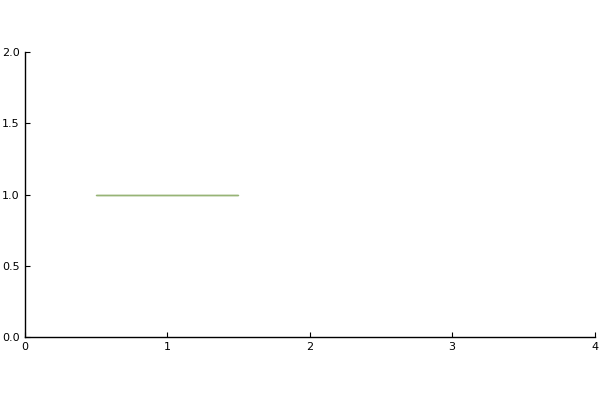

In [7]:
plot(body,xlim=(0,4),ylim=(0,2))

Now set up the coordinate data for operator construction

In [8]:
X = VectorData(body.x,body.y);
X̃ = VectorData(body.x̃,body.ỹ);

Set the domain size and time step size

In [9]:
nx = 202; ny = 102;
Ly = 2.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re);
w₀ = Nodes(Dual,(nx,ny));
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:4.01, -0.01:0.02:2.0100000000000002)

### Now start constructing operators

#### Set up the state vector and constraint force vector for a moving body

In [10]:
u = (w₀,[real(cent),imag(cent),α])
f = (VectorData(X̃),Vector{Float64}());
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, isstore = true, isstatic = false)

Navier-Stokes system on a grid of size 202 x 102

In [11]:
ifherk = IFHERK(u,f,sys.Δt,
                ((t,u) -> Systems.plan_intfact(t,u,sys),
                 (t,u) -> eye(3)),
                (u,t) -> TimeMarching.plan_constraints(u,t,sys),
                ((u,t) -> Systems.r₁(u,t,sys,motion),
                 (u,t) -> Systems.r₂(u,t,sys,motion)),tol=1e-3,rk=TimeMarching.RK31,isstored=true,isstaticconstraints=false)

i=Integrating factor with parameter 0.0625 on a (nx = 202, ny = 102) grid
i=[1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
i=Integrating factor with parameter 0.0 on a (nx = 202, ny = 102) grid
i=[1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]


Order-3 IF-HERK integrator with
   State of type Tuple{Whirl.Fields.Nodes{Whirl.Fields.Dual,202,102},Array{Float64,1}}
   Force of type Tuple{Whirl.Fields.VectorData{51},Array{Float64,1}}
   Time step size 0.01


In [12]:
t = 0.0
w₀ .= 0.0
u = (w₀,[real(cent),imag(cent),α])
f = (VectorData(X̃),Vector{Float64}());
tf = 0.01;
T = Δt:Δt:tf;
fx = Float64[];
fy = Float64[];
thist = [];
uhist = [];
tsample = 0.02;

In [13]:
@time for ti in T
    t, u, f = ifherk(t,u)
    
    # save data for later use
    push!(thist,t)
    push!(fx,sum(f[1].u)*Δx^2)
    push!(fy,sum(f[1].v)*Δx^2)
    (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(uhist,deepcopy(u)) : nothing
end
println("solution completed through time t = ",t)

i=Integrating factor with parameter 0.0625 on a (nx = 202, ny = 102) grid
i=[1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
i=Integrating factor with parameter 0.0625 on a (nx = 202, ny = 102) grid
i=[1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
i=Integrating factor with parameter 0.0 on a (nx = 202, ny = 102) grid
i=[1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 10.177178 seconds (59.32 M allocations: 10.826 GiB, 13.64% gc time)
solution completed through time t = 0.01


In [14]:
f

(51 points of vector-valued data
, Float64[])

In [15]:
plot(xg,yg,uhist[1][1],levels=linspace(-0.25,0.25,30))
Tr = RigidTransform(uhist[1][2])
Tr(body) # transform the body to the current configuration
plot!(body,linecolor=:black)

LoadError: [91mBoundsError: attempt to access 0-element Array{Any,1} at index [1][39m

In [16]:
plot(xg,yg,uhist[end][1],levels=linspace(-0.25,0.25,30))
Tr = RigidTransform(uhist[end][2])
Tr(body) # transform the body to the current configuration
plot!(body,linecolor=:black)

LoadError: [91mBoundsError: attempt to access 0-element Array{Any,1} at index [0][39m

In [17]:
f[1].u

51-element Array{Float64,1}:
 -1427.92 
   558.705
 -1085.42 
   540.423
  -971.049
   492.884
  -877.147
   434.583
  -790.287
   371.51 
  -706.853
   305.906
  -625.368
     ⋮    
  -660.081
   478.535
  -726.699
   560.538
  -791.413
   645.036
  -852.609
   734.259
  -905.557
   833.894
  -932.403
   983.09 

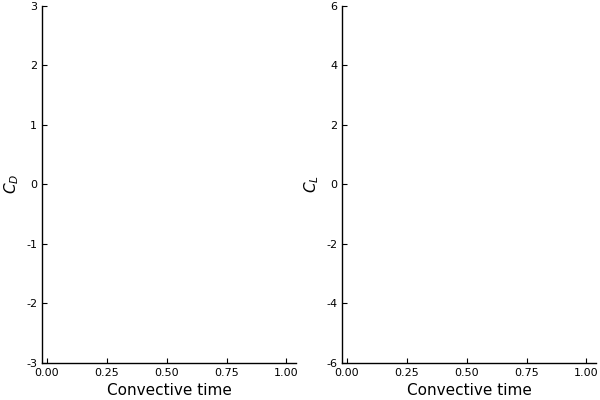

In [18]:
px = plot(thist,2*fx,ylim=(-3,3),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(-6,6),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

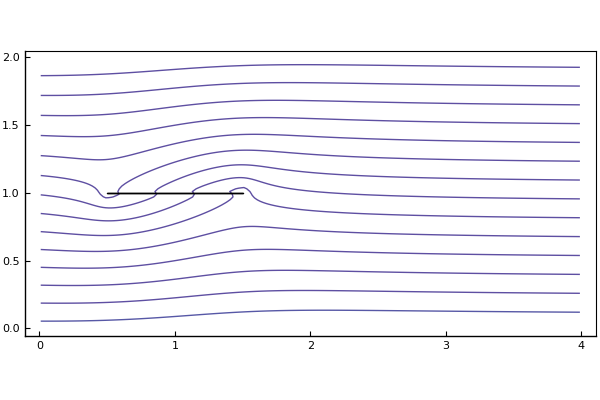

/home/julia/JuliaPro-0.6.2.2/JuliaPro/pkgs-0.6.2.2/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'label'
  s)


In [19]:
ψ = deepcopy(u[1])
ψ .= -(sys.L\u[1])*Δx .+ repmat(collect(yg)',202,1)
plot(xg,yg,ψ,trim=1,clim=(-0.1,0.1))
plot!(body,fillcolor=:black,linecolor=:black)